# GFDL FLOR Forecast

- Loads in all monthly/daily forecasts of sea ice extent
- Regrids to polar stereographic,
- Saves to netcdf files grouped by year

In [1]:
# Standard Imports
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import scipy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import xesmf as xe
import os
import glob
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ESIO Imports
import esio

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
# Directories
model='gfdlsipn'
runType='forecast'
base_dir = r'/home/disk/sipn/nicway/data/'
ftp_dir = r'/home/disk/sipn/upload/'
data_dir = os.path.join(ftp_dir, model, runType)
data_out = os.path.join(base_dir, 'model', model, runType, 'sipn_nc')
model_grid_file = os.path.join(base_dir, 'grids', 'GFDLFLOR_gridinfo.nc' )
stero_grid_file = os.path.join(base_dir, 'grids', 'stereo_gridinfo.nc')

In [4]:
data_dir

'/home/disk/sipn/upload/gfdlsipn/forecast'

In [5]:
gfdl_grid = esio.load_grid_info(model_grid_file, model='GFDL')
gfdl_grid.dims

Frozen(SortedKeysDict({'nj': 200, 'ni': 360, 'nj_b': 201, 'ni_b': 361}))

In [6]:
# # Plot the input Grid
# %matplotlib notebook
# plt.figure(figsize=(10,8));
# ax1 = plt.axes(projection=ccrs.PlateCarree())
# ax1.scatter(gfdl_grid['lon_b'], gfdl_grid['lat_b'], s=6, c='r', transform=ccrs.PlateCarree())  # plot grid locations
# ax1.scatter(gfdl_grid['lon'], gfdl_grid['lat'], s=3, c='b', transform=ccrs.PlateCarree())  # plot grid locations
# plt.xlabel('lon')
# plt.ylabel('lat')

In [7]:
# # Plot the input Grid
# %matplotlib notebook
# plt.figure(figsize=(10,8));
# ax1 = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
# ax1.scatter(gfdl_grid['lon_b'], gfdl_grid['lat_b'], s=6, c='r', transform=ccrs.PlateCarree())  # plot grid locations
# ax1.scatter(gfdl_grid['lon'], gfdl_grid['lat'], s=3, c='b', transform=ccrs.PlateCarree())  # plot grid locations
# plt.xlabel('lon')
# plt.ylabel('lat')

In [8]:
obs_grid = esio.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [9]:
# Regridding Options
method='bilinear' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

In [10]:
weights_flag = False # Flag to set up weights have been created

# ice_CN_032018_05.nc
# GFDL model variable names
varnames = ['CN', 'HI']

for year in np.arange(2018, 2025, 1):
    # Check any files for this year exist:
    if not glob.glob(os.path.join(data_dir, '*'+str(year)+'*.nc')):
        print("No files found for year ", year, ".")
        continue
    print("Procesing year ", year)
    ds_var_list = []
    for varname in varnames:
        # Loop over each ensemble member
        ds_list = []
        for e in np.arange(1,13,1):
            cfiles = os.path.join(data_dir, 'ice_daily_'+varname+'*'+str(year)+'_'+format(e, '02')+'.nc')
            ds_list.append(esio.open_1_member(cfiles, e))
        ds_var_list.append(xr.concat(ds_list, dim='ensemble')) # conact ensembles
        
    # Merge variables
    ds_all = xr.merge(ds_var_list)

    # Fix GFDL grid
    # Files comes with incorrect lat/lon at poles. Use correct separate file to update coords
    ds_all.rename({'yt':'nj', 'xt':'ni'}, inplace=True); # Rename wrong-lat/lon to indices
    ds_all.coords['nj'] = gfdl_grid.nj
    ds_all.coords['ni'] = gfdl_grid.ni
    ds_all.coords['lat'] = gfdl_grid.lat
    ds_all.coords['lon'] = gfdl_grid.lon
    ds_all.coords['lat_b'] = gfdl_grid.lat_b
    ds_all.coords['lon_b'] = gfdl_grid.lon_b
    
    # Split up grid into "top" and "bottom"
    (ds_top, ds_bottom) = esio.split_GFDL(ds_all, varnames=varnames)
    
    # Calculate regridding matrix
    regridder_top = xe.Regridder(ds_top, obs_grid, method, periodic=False, reuse_weights=weights_flag)
    regridder_bottom = xe.Regridder(ds_bottom, obs_grid, method, periodic=False, reuse_weights=weights_flag)
    weights_flag = True # Set true for following loops
    
    # Add NaNs to empty rows of matrix (forces any target cell with ANY source cells containing NaN to be NaN)
    regridder_top = esio.add_matrix_NaNs(regridder_top)
    regridder_bottom = esio.add_matrix_NaNs(regridder_bottom)
    
    # Average over all sea ice categories 
    native_top = ds_top.sum(dim='ct', skipna=False)
    native_bottom = ds_bottom.sum(dim='ct', skipna=False)
    
    # Loop through each variable (xemsf not dataset enabled yet)
    da_out_all_list = []
    for cvar in native_top.data_vars:
        da_out_all_list.append( esio.regrid_gfdl_split_domain(ds_all, native_top[cvar], native_bottom[cvar],
                                                              regridder_top, regridder_bottom))
    ds_out_all = xr.merge(da_out_all_list)

    # Rename to common sipn variable names
    ds_out_all = ds_out_all.rename({'CN':'sic','HI':'hi'})
    
    # Expand dims
    ds_out_all = esio.expand_to_sipn_dims(ds_out_all)
    
    # # Save regridded to netcdf file
    f_out = os.path.join(data_out, 'GFDL_FLOR_'+str(year)+'_Stereo.nc')
    ds_out_all.to_netcdf(f_out)
    ds_out_all = None # Memory clean up
    print('Saved ', f_out)
    

Procesing year  2018
Overwrite existing file: bilinear_50x180_304x448.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_185x360_304x448.nc 
 You can set reuse_weights=True to save computing time.


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Saved  /home/disk/sipn/nicway/data/model/gfdlsipn/forecast/sipn_nc/GFDL_FLOR_2018_Stereo.nc
No files found for year  2019 .
No files found for year  2020 .
No files found for year  2021 .
No files found for year  2022 .
No files found for year  2023 .
No files found for year  2024 .


In [11]:
# Clean up
regridder_top.clean_weight_file()  # clean-up
regridder_bottom.clean_weight_file()  # clean-up

Remove file bilinear_50x180_304x448.nc
Remove file bilinear_185x360_304x448.nc


# Plotting

In [12]:
ds_new = xr.open_dataset(f_out)


In [13]:
ds_new

<xarray.Dataset>
Dimensions:    (ensemble: 12, fore_time: 365, init_time: 1, ni: 448, nj: 304)
Coordinates:
    lon        (nj, ni) float64 ...
    lat        (nj, ni) float64 ...
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * fore_time  (fore_time) timedelta64[ns] 0 days 1 days 2 days 3 days ...
  * init_time  (init_time) datetime64[ns] 2018-03-01
Dimensions without coordinates: ni, nj
Data variables:
    sic        (init_time, ensemble, fore_time, nj, ni) float64 ...
    hi         (init_time, ensemble, fore_time, nj, ni) float64 ...

KeyError: 'HI'

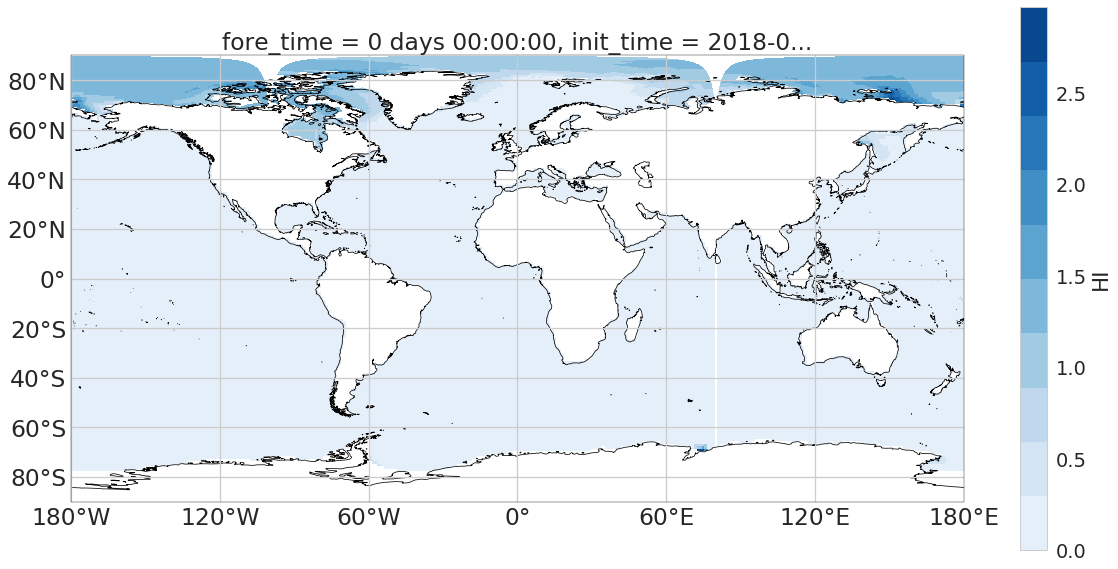

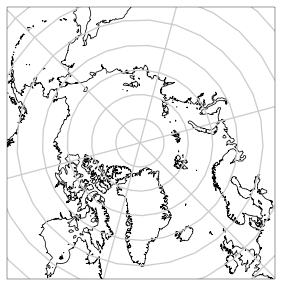

In [14]:

# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_sic.set_bad(color = 'green')

# Pick forecast lead time and ensemble member to plot
FT=0
E=0
it=0
var='HI'

# Plot original projection
plt.figure(figsize=(20,10))
ax1 = plt.axes(projection=ccrs.PlateCarree())
ds_p = ds_all[var].isel(fore_time=FT).isel(ensemble=E) #.sum(dim='ct')
ds_p.plot.pcolormesh(ax=ax1, x='lon', y='lat',
                                 cmap=matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10)),
                    transform=ccrs.PlateCarree());
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.coastlines(linewidth=0.75, color='black', resolution='50m');


# Plot SIC on target projection
(f, ax1) = esio.polar_axis()
ds_p2 = ds_new[var].isel(fore_time=FT).isel(ensemble=E).isel(init_time=it)
ds_p2.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
ax1.set_title('Target Grid')
